In [1]:
# Manage data and statistics
import numpy as np
from numpy.random import default_rng, SeedSequence
import pandas as pd

from scipy import stats
from scipy.stats import norm, skewnorm, yeojohnson, boxcox, zscore
from scipy.stats.mstats import winsorize

# Plot data
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
sns.set(style="white")

# Scale variables
from sklearn.preprocessing import scale, StandardScaler
from sklearn.preprocessing import minmax_scale, MinMaxScaler
from sklearn.preprocessing import maxabs_scale, MaxAbsScaler
from sklearn.preprocessing import robust_scale, RobustScaler

# Transform variables
from sklearn.preprocessing import quantile_transform, QuantileTransformer
from sklearn.preprocessing import power_transform, PowerTransformer

# Encode categorical variables
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder

# Discretize continuous variables
from sklearn.preprocessing import KBinsDiscretizer

# Impute missing values
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [2]:
data = {
    'id': [1000, 1001, 1002, 1003, 1004, 1005, 1006],
    'date': pd.date_range('4/25/2020', periods=7, freq='D'),
    'age': [21, 56, 33, 48, 27, 42, 32],
    'income': [67000, 220000, 97000, 166000, 81000, 157000, 96000],
    'gender': ['Male', 'Female', 'Female', 'Male', 'Male', 'Female', 'Female'],
    'education': ['Bachelors', 'PhD', 'Masters', 'Masters', 'Bachelors', 'Bachelors', 'Bachelors'], 
    'passed': [False, True, True, True, False, False, True],
    'measurement': np.random.randn(7).round(2)
}

df = pd.DataFrame(data)
df

,id,date,age,income,gender,education,passed,measurement
0,1000,2020-04-25,21,67000,Male,Bachelors,False,0.75
1,1001,2020-04-26,56,220000,Female,PhD,True,-1.34
2,1002,2020-04-27,33,97000,Female,Masters,True,-1.14
3,1003,2020-04-28,48,166000,Male,Masters,True,0.69
4,1004,2020-04-29,27,81000,Male,Bachelors,False,0.43
5,1005,2020-04-30,42,157000,Female,Bachelors,False,-1.14
6,1006,2020-05-01,32,96000,Female,Bachelors,True,0.84


In [3]:
# Insert missing values into the dataset
df2 = df.copy()
df2.iloc[[3, 5], [2, 4, 5, 6, 7]] = np.nan
df2

,id,date,age,income,gender,education,passed,measurement
0,1000,2020-04-25,21.0,67000,Male,Bachelors,False,0.75
1,1001,2020-04-26,56.0,220000,Female,PhD,True,-1.34
2,1002,2020-04-27,33.0,97000,Female,Masters,True,-1.14
3,1003,2020-04-28,NaN,166000,NaN,NaN,NaN,NaN
4,1004,2020-04-29,27.0,81000,Male,Bachelors,False,0.43
5,1005,2020-04-30,NaN,157000,NaN,NaN,NaN,NaN
6,1006,2020-05-01,32.0,96000,Female,Bachelors,True,0.84


## 1a. Create indicator variable for missing values in `age` column
## 1b. Fill in missing values in `age` column using `pandas`

In [4]:
df2['age_imputed'] = np.where(df2['age'].isna(), 1.0, 0.0)
df2

,id,date,age,income,gender,education,passed,measurement,age_imputed
0,1000,2020-04-25,21.0,67000,Male,Bachelors,False,0.75,0.0
1,1001,2020-04-26,56.0,220000,Female,PhD,True,-1.34,0.0
2,1002,2020-04-27,33.0,97000,Female,Masters,True,-1.14,0.0
3,1003,2020-04-28,NaN,166000,NaN,NaN,NaN,NaN,1.0
4,1004,2020-04-29,27.0,81000,Male,Bachelors,False,0.43,0.0
5,1005,2020-04-30,NaN,157000,NaN,NaN,NaN,NaN,1.0
6,1006,2020-05-01,32.0,96000,Female,Bachelors,True,0.84,0.0


In [5]:
np.round(df2['age'].mean(), 2)

33.8

In [6]:
# Fill in, in-place

# df2['age'].fillna(df2['age'].mean(), inplace=True)
# df2

In [7]:
# Fill in missing values with column mean
df2['age_imp_w_pandas'] = df2['age']

df2.loc[df2['age_imp_w_pandas'].isnull(), 'age_imp_w_pandas'] = df2['age_imp_w_pandas'].mean() # df2.loc[~df2['age'].isnull(), 'age'].mean()

df2

,id,date,age,income,gender,education,passed,measurement,age_imputed,age_imp_w_pandas
0,1000,2020-04-25,21.0,67000,Male,Bachelors,False,0.75,0.0,21.0
1,1001,2020-04-26,56.0,220000,Female,PhD,True,-1.34,0.0,56.0
2,1002,2020-04-27,33.0,97000,Female,Masters,True,-1.14,0.0,33.0
3,1003,2020-04-28,NaN,166000,NaN,NaN,NaN,NaN,1.0,33.8
4,1004,2020-04-29,27.0,81000,Male,Bachelors,False,0.43,0.0,27.0
5,1005,2020-04-30,NaN,157000,NaN,NaN,NaN,NaN,1.0,33.8
6,1006,2020-05-01,32.0,96000,Female,Bachelors,True,0.84,0.0,32.0


## 2. Fill in missing values in `age` column using `scikit-learn`

In [8]:
# Fill in missing values with column mean
df2['age_imp_w_sklearn'] = df2['age']

imp = SimpleImputer(missing_values=np.nan, strategy='mean')

df2['age_imp_w_sklearn'] = pd.Series( imp.fit_transform(df2['age'].values.reshape(-1, 1)).flatten() )

df2

,id,date,age,income,gender,education,passed,measurement,age_imputed,age_imp_w_pandas,age_imp_w_sklearn
0,1000,2020-04-25,21.0,67000,Male,Bachelors,False,0.75,0.0,21.0,21.0
1,1001,2020-04-26,56.0,220000,Female,PhD,True,-1.34,0.0,56.0,56.0
2,1002,2020-04-27,33.0,97000,Female,Masters,True,-1.14,0.0,33.0,33.0
3,1003,2020-04-28,NaN,166000,NaN,NaN,NaN,NaN,1.0,33.8,33.8
4,1004,2020-04-29,27.0,81000,Male,Bachelors,False,0.43,0.0,27.0,27.0
5,1005,2020-04-30,NaN,157000,NaN,NaN,NaN,NaN,1.0,33.8,33.8
6,1006,2020-05-01,32.0,96000,Female,Bachelors,True,0.84,0.0,32.0,32.0


## 3a. Create indicator variable for missing values in `education` column
## 3b. Fill in missing values in `education` column using `pandas`

In [9]:
df2['education_imputed'] = np.where(df2['education'].isna(), 1.0, 0.0)
df2

,id,date,age,income,gender,education,passed,measurement,age_imputed,age_imp_w_pandas,age_imp_w_sklearn,education_imputed
0,1000,2020-04-25,21.0,67000,Male,Bachelors,False,0.75,0.0,21.0,21.0,0.0
1,1001,2020-04-26,56.0,220000,Female,PhD,True,-1.34,0.0,56.0,56.0,0.0
2,1002,2020-04-27,33.0,97000,Female,Masters,True,-1.14,0.0,33.0,33.0,0.0
3,1003,2020-04-28,NaN,166000,NaN,NaN,NaN,NaN,1.0,33.8,33.8,1.0
4,1004,2020-04-29,27.0,81000,Male,Bachelors,False,0.43,0.0,27.0,27.0,0.0
5,1005,2020-04-30,NaN,157000,NaN,NaN,NaN,NaN,1.0,33.8,33.8,1.0
6,1006,2020-05-01,32.0,96000,Female,Bachelors,True,0.84,0.0,32.0,32.0,0.0


In [10]:
# Fill in, in-place

# df2['education'].fillna('Unknown', inplace=True)
# df2

In [11]:
# Fill in missing values with a constant
df2['edu_imp_w_pandas'] = df2['education']

df2.loc[df2['edu_imp_w_pandas'].isnull(), 'edu_imp_w_pandas'] = 'Unknown'

df2

,id,date,age,income,gender,education,passed,measurement,age_imputed,age_imp_w_pandas,age_imp_w_sklearn,education_imputed,edu_imp_w_pandas
0,1000,2020-04-25,21.0,67000,Male,Bachelors,False,0.75,0.0,21.0,21.0,0.0,Bachelors
1,1001,2020-04-26,56.0,220000,Female,PhD,True,-1.34,0.0,56.0,56.0,0.0,PhD
2,1002,2020-04-27,33.0,97000,Female,Masters,True,-1.14,0.0,33.0,33.0,0.0,Masters
3,1003,2020-04-28,NaN,166000,NaN,NaN,NaN,NaN,1.0,33.8,33.8,1.0,Unknown
4,1004,2020-04-29,27.0,81000,Male,Bachelors,False,0.43,0.0,27.0,27.0,0.0,Bachelors
5,1005,2020-04-30,NaN,157000,NaN,NaN,NaN,NaN,1.0,33.8,33.8,1.0,Unknown
6,1006,2020-05-01,32.0,96000,Female,Bachelors,True,0.84,0.0,32.0,32.0,0.0,Bachelors


## 4. Fill in missing values in `education` column using `scikit-learn`

In [12]:
# Fill in missing values with a constant
df2['edu_imp_w_sklearn'] = df2['education']

imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Unknown')

df2['edu_imp_w_sklearn'] = pd.Series( imp.fit_transform(df2['education'].values.reshape(-1, 1)).flatten() )

df2

,id,date,age,income,gender,education,passed,measurement,age_imputed,age_imp_w_pandas,age_imp_w_sklearn,education_imputed,edu_imp_w_pandas,edu_imp_w_sklearn
0,1000,2020-04-25,21.0,67000,Male,Bachelors,False,0.75,0.0,21.0,21.0,0.0,Bachelors,Bachelors
1,1001,2020-04-26,56.0,220000,Female,PhD,True,-1.34,0.0,56.0,56.0,0.0,PhD,PhD
2,1002,2020-04-27,33.0,97000,Female,Masters,True,-1.14,0.0,33.0,33.0,0.0,Masters,Masters
3,1003,2020-04-28,NaN,166000,NaN,NaN,NaN,NaN,1.0,33.8,33.8,1.0,Unknown,Unknown
4,1004,2020-04-29,27.0,81000,Male,Bachelors,False,0.43,0.0,27.0,27.0,0.0,Bachelors,Bachelors
5,1005,2020-04-30,NaN,157000,NaN,NaN,NaN,NaN,1.0,33.8,33.8,1.0,Unknown,Unknown
6,1006,2020-05-01,32.0,96000,Female,Bachelors,True,0.84,0.0,32.0,32.0,0.0,Bachelors,Bachelors


## 5. Create dummy variables based on the `education` column using `pandas`

In [13]:
# To keep the new columns, set the result equal to a new variable, e.g. df3
pd.get_dummies(data=df2, 
               columns=['education'], 
               prefix=['edu'], 
               dtype=float)

,id,date,age,income,gender,passed,measurement,age_imputed,age_imp_w_pandas,age_imp_w_sklearn,education_imputed,edu_imp_w_pandas,edu_imp_w_sklearn,edu_Bachelors,edu_Masters,edu_PhD
0,1000,2020-04-25,21.0,67000,Male,False,0.75,0.0,21.0,21.0,0.0,Bachelors,Bachelors,1.0,0.0,0.0
1,1001,2020-04-26,56.0,220000,Female,True,-1.34,0.0,56.0,56.0,0.0,PhD,PhD,0.0,0.0,1.0
2,1002,2020-04-27,33.0,97000,Female,True,-1.14,0.0,33.0,33.0,0.0,Masters,Masters,0.0,1.0,0.0
3,1003,2020-04-28,NaN,166000,NaN,NaN,NaN,1.0,33.8,33.8,1.0,Unknown,Unknown,0.0,0.0,0.0
4,1004,2020-04-29,27.0,81000,Male,False,0.43,0.0,27.0,27.0,0.0,Bachelors,Bachelors,1.0,0.0,0.0
5,1005,2020-04-30,NaN,157000,NaN,NaN,NaN,1.0,33.8,33.8,1.0,Unknown,Unknown,0.0,0.0,0.0
6,1006,2020-05-01,32.0,96000,Female,True,0.84,0.0,32.0,32.0,0.0,Bachelors,Bachelors,1.0,0.0,0.0


## 6. Create dummy variables based on the `education` column using `scikit-learn`

In [14]:
ohe = OneHotEncoder()
ohe.fit_transform( df['education'].values.reshape(-1, 1) ).toarray()

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

## 7a. Create a centered and scaled version of the `age` column using `pandas`
## 7b. Plot the two distributions, original and centered & scaled, side-by-side 

In [15]:
# Fill NAs with column mean, in-place
df2['age'].fillna(df2['age'].mean(), inplace=True)

df2['age_cs'] = df2['age'].apply(lambda val: (val - df2['age'].mean()) / df2['age'].std())
df2

,id,date,age,income,gender,education,passed,measurement,age_imputed,age_imp_w_pandas,age_imp_w_sklearn,education_imputed,edu_imp_w_pandas,edu_imp_w_sklearn,age_cs
0,1000,2020-04-25,21.0,67000,Male,Bachelors,False,0.75,0.0,21.0,21.0,0.0,Bachelors,Bachelors,-1.179335e+00
1,1001,2020-04-26,56.0,220000,Female,PhD,True,-1.34,0.0,56.0,56.0,0.0,PhD,PhD,2.045410e+00
2,1002,2020-04-27,33.0,97000,Female,Masters,True,-1.14,0.0,33.0,33.0,0.0,Masters,Masters,-7.370846e-02
3,1003,2020-04-28,33.8,166000,NaN,NaN,NaN,NaN,1.0,33.8,33.8,1.0,Unknown,Unknown,-6.546626e-16
4,1004,2020-04-29,27.0,81000,Male,Bachelors,False,0.43,0.0,27.0,27.0,0.0,Bachelors,Bachelors,-6.265219e-01
5,1005,2020-04-30,33.8,157000,NaN,NaN,NaN,NaN,1.0,33.8,33.8,1.0,Unknown,Unknown,-6.546626e-16
6,1006,2020-05-01,32.0,96000,Female,Bachelors,True,0.84,0.0,32.0,32.0,0.0,Bachelors,Bachelors,-1.658440e-01


In [16]:
df2['age_cs'].mean(), df2['age_cs'].std()

(-5.075305255429287e-16, 1.0)

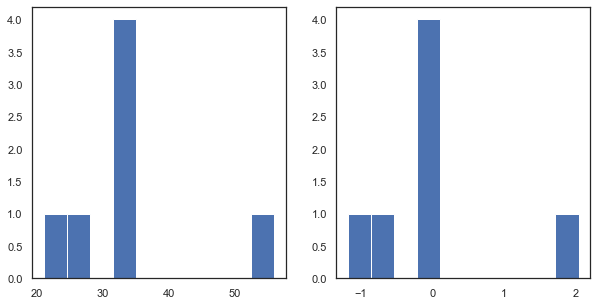

In [17]:
fig, axs = plt.subplots(figsize=(10, 5), ncols=2)

axs[0].hist(df2['age'])
axs[1].hist(df2['age_cs']);

### Random normal variable

In [18]:
sq1 = np.random.SeedSequence()
sq1.entropy

152265842684605181656364628858012706441

In [19]:
rng = default_rng(sq1.entropy)

In [20]:
vals = norm.rvs(loc=55, scale=3, size=1000, random_state=rng)

vals.mean(), vals.std()

(54.987986191019786, 3.075143259592001)

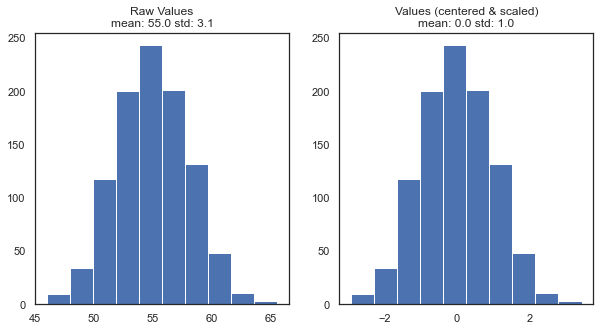

In [21]:
fig, axs = plt.subplots(figsize=(10, 5), ncols=2)

axs[0].hist(vals)
axs[0].set_title('Raw Values\nmean: {:.1f} std: {:.1f}'.format( vals.mean(), vals.std() ))

vals_cs = (vals - vals.mean()) / vals.std()

axs[1].hist(vals_cs)
axs[1].set_title('Values (centered & scaled)\nmean: {:.1f} std: {:.1f}'.format( abs(vals_cs.mean()), vals_cs.std() ));

## 8a. Transform skewed distribution to Gaussian using `ladder of powers`
## 8b. Plot the distributions side-by-side

In [22]:
r = pd.Series(skewnorm.rvs(a=4, loc=10, scale=4, size=1000))

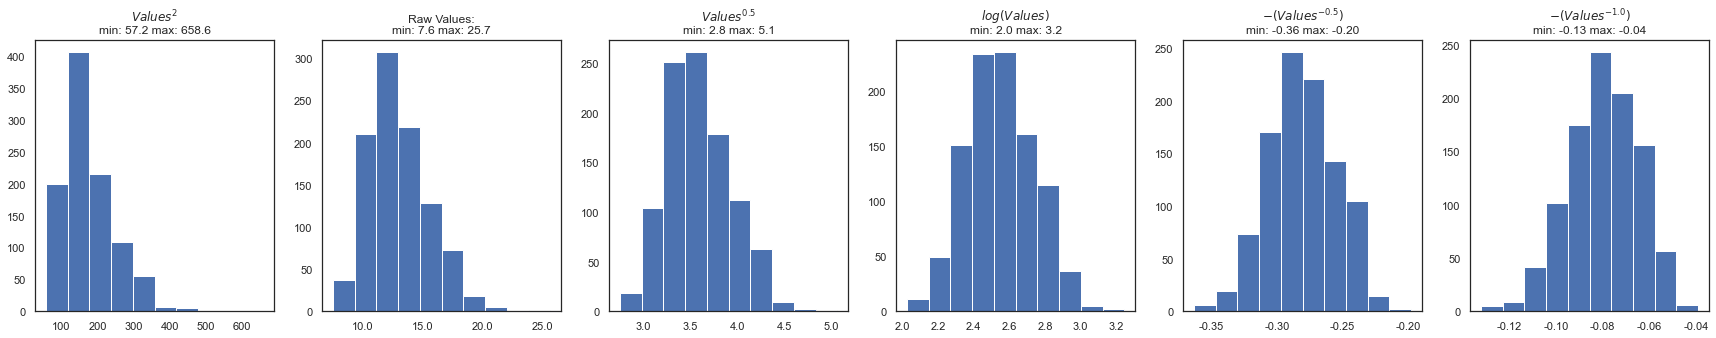

In [23]:
fig, axs = plt.subplots(figsize=(30, 5), ncols=6)

axs[0].hist(np.power(r, 2))
axs[0].set_title('$Values^2$\nmin: {:.1f} max: {:.1f}'.format(np.min(np.power(r, 2)), np.max(np.power(r, 2))))

x_min, x_max = np.min(-np.power(r, -0.5)), np.max(r)

axs[1].hist(r)
axs[1].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axs[1].set_title('Raw Values:\nmin: {:.1f} max: {:.1f}'.format(np.min(r), np.max(r)))

axs[2].hist(np.power(r, 0.5))
axs[2].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axs[2].set_title('$Values^{0.5}$'+'\nmin: {0:.1f} max: {1:.1f}'.format(np.min(np.power(r, 0.5)), np.max(np.power(r, 0.5))))

axs[3].hist(np.log(r))
axs[3].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axs[3].set_title('$log(Values)$\nmin: {:.1f} max: {:.1f}'.format(np.min(np.log(r)), np.max(np.log(r))))

axs[4].hist(-np.power(r, -0.5))
axs[4].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs[4].set_title('$-(Values^{-0.5})$'+'\nmin: {:.2f} max: {:.2f}'.format(np.min(-np.power(r, -0.5)), np.max(-np.power(r, -0.5))))

axs[5].hist(-(1/r))
axs[5].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs[5].set_title('$-(Values^{-1.0})$'+'\nmin: {:.2f} max: {:.2f}'.format(np.min(-(1/r)), np.max(-(1/r))));

## 9a. Transform skewed distribution to Gaussian using `scipy`
## 9b. Plot the distributions, original and transformed, side-by-side

In [24]:
s = pd.Series(skewnorm.rvs(a=4, loc=10, scale=4, size=1000))

In [25]:
s_yj, lambda_ = yeojohnson(s)

print('mean (original): {}  mean (yeo-johnson): {} \nstd  (original): {}   std  (yeo-johnson): {}  \nlambda: {}'.format(round(s.mean(), 2), round(s_yj.mean(), 2), 
round(s.std(), 2), round(s_yj.std(), 2), 
round(lambda_, 2)
))

mean (original): 12.96  mean (yeo-johnson): 1.24 
std  (original): 2.43   std  (yeo-johnson): 0.03  
lambda: -0.66


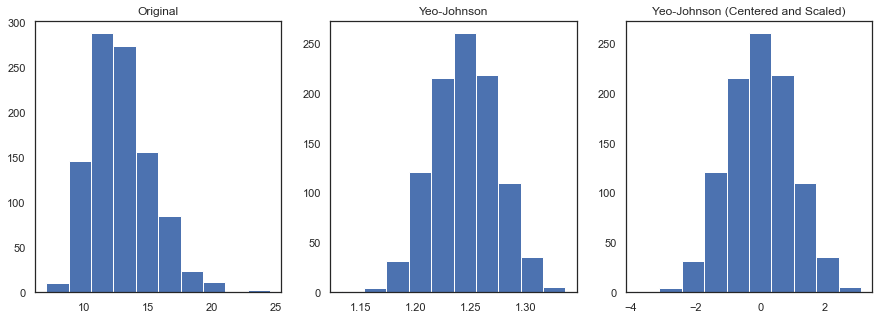

In [26]:
fig, axs = plt.subplots(figsize=(15, 5), ncols=3)
axs[0].hist(s)
axs[0].set_title('Original')

axs[1].hist(s_yj)
axs[1].set_title('Yeo-Johnson')

axs[2].hist(zscore(s_yj))
axs[2].set_title('Yeo-Johnson (Centered and Scaled)');

## 10a. Transform skewed distribution to Gaussian using `scikit-learn`
## 10b. Plot the two distributions, original and transformed, side-by-side

In [27]:
t = pd.Series(skewnorm.rvs(a=4, loc=10, scale=4, size=1000))

In [28]:
pt1 = PowerTransformer(method='yeo-johnson', standardize=False)
pt2 = PowerTransformer(method='yeo-johnson', standardize=True)

t_yj1 = pt1.fit_transform(t.values.reshape(-1, 1))
t_yj2 = pt2.fit_transform(t.values.reshape(-1, 1))

print('mean (original): {}  mean (yeo-johnson): {} \nstd  (original): {}   std  (yeo-johnson): {}  \nlambda: {}'.format(round(t.mean(), 2), round(t_yj1.mean(), 2), 
round(t.std(), 2), round(t_yj1.std(), 2), 
round(pt1.lambdas_[0], 2)
))

mean (original): 13.03  mean (yeo-johnson): 1.6 
std  (original): 2.42   std  (yeo-johnson): 0.06  
lambda: -0.42


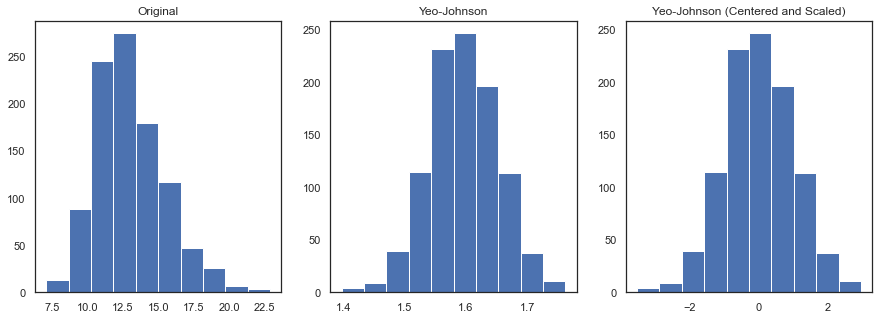

In [29]:
fig, axs = plt.subplots(figsize=(15, 5), ncols=3)
axs[0].hist(t)
axs[0].set_title('Original')

axs[1].hist(t_yj1)
axs[1].set_title('Yeo-Johnson')

axs[2].hist(t_yj2)
axs[2].set_title('Yeo-Johnson (Centered and Scaled)');